In [1]:
!pip install -q matplotlib opencv-python tqdm tensorboardX

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from torchvision.utils import make_grid, save_image
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor
from torch.nn import functional as F

from matplotlib import pyplot as plt
from PIL import Image
import os
import cv2
from typing import Any
import numpy as np
import math
import random
from tqdm import tqdm
from tensorboardX import SummaryWriter

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using device {}".format(device))

Using device cuda:0


In [4]:
# Fixed random number seed
SEED = 99

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
def _cubic(x: Any) -> Any:
    """Implementation of `cubic` function in Matlab under Python language.

    Args:
        x: Element vector.

    Returns:
        Bicubic interpolation

    """
    absx = torch.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3
    return (1.5 * absx3 - 2.5 * absx2 + 1) * ((absx <= 1).type_as(absx)) + (
            -0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2) * (
        ((absx > 1) * (absx <= 2)).type_as(absx))


def _calculate_weights_indices(in_length: int,
                               out_length: int,
                               scale: float,
                               kernel_width: int,
                               antialiasing: bool) -> [np.ndarray, np.ndarray, int, int]:
    """Implementation of `calculate_weights_indices` function in Matlab under Python language.

    Args:
        in_length (int): Input length.
        out_length (int): Output length.
        scale (float): Scale factor.
        kernel_width (int): Kernel width.
        antialiasing (bool): Whether to apply antialiasing when down-sampling operations.
            Caution: Bicubic down-sampling in PIL uses antialiasing by default.

    Returns:
       weights, indices, sym_len_s, sym_len_e

    """
    if (scale < 1) and antialiasing:
        # Use a modified kernel (larger kernel width) to simultaneously
        # interpolate and antialiasing
        kernel_width = kernel_width / scale

    # Output-space coordinates
    x = torch.linspace(1, out_length, out_length)

    # Input-space coordinates. Calculate the inverse mapping such that 0.5
    # in output space maps to 0.5 in input space, and 0.5 + scale in output
    # space maps to 1.5 in input space.
    u = x / scale + 0.5 * (1 - 1 / scale)

    # What is the left-most pixel that can be involved in the computation?
    left = torch.floor(u - kernel_width / 2)

    # What is the maximum number of pixels that can be involved in the
    # computation?  Note: it's OK to use an extra pixel here; if the
    # corresponding weights are all zero, it will be eliminated at the end
    # of this function.
    p = math.ceil(kernel_width) + 2

    # The indices of the input pixels involved in computing the k-th output
    # pixel are in row k of the indices matrix.
    indices = left.view(out_length, 1).expand(out_length, p) + torch.linspace(0, p - 1, p).view(1, p).expand(
        out_length, p)

    # The weights used to compute the k-th output pixel are in row k of the
    # weights matrix.
    distance_to_center = u.view(out_length, 1).expand(out_length, p) - indices

    # apply cubic kernel
    if (scale < 1) and antialiasing:
        weights = scale * _cubic(distance_to_center * scale)
    else:
        weights = _cubic(distance_to_center)

    # Normalize the weights matrix so that each row sums to 1.
    weights_sum = torch.sum(weights, 1).view(out_length, 1)
    weights = weights / weights_sum.expand(out_length, p)

    # If a column in weights is all zero, get rid of it. only consider the
    # first and last column.
    weights_zero_tmp = torch.sum((weights == 0), 0)
    if not math.isclose(weights_zero_tmp[0], 0, rel_tol=1e-6):
        indices = indices.narrow(1, 1, p - 2)
        weights = weights.narrow(1, 1, p - 2)
    if not math.isclose(weights_zero_tmp[-1], 0, rel_tol=1e-6):
        indices = indices.narrow(1, 0, p - 2)
        weights = weights.narrow(1, 0, p - 2)
    weights = weights.contiguous()
    indices = indices.contiguous()
    sym_len_s = -indices.min() + 1
    sym_len_e = indices.max() - in_length
    indices = indices + sym_len_s - 1
    return weights, indices, int(sym_len_s), int(sym_len_e)


def image_resize(image: Any, scale_factor: float, antialiasing: bool = True) -> Any:
    """Implementation of `imresize` function in Matlab under Python language.

    Args:
        image: The input image.
        scale_factor (float): Scale factor. The same scale applies for both height and width.
        antialiasing (bool): Whether to apply antialiasing when down-sampling operations.
            Caution: Bicubic down-sampling in `PIL` uses antialiasing by default. Default: ``True``.

    Returns:
        out_2 (np.ndarray): Output image with shape (c, h, w), [0, 1] range, w/o round

    """
    squeeze_flag = False
    if type(image).__module__ == np.__name__:  # numpy type
        numpy_type = True
        if image.ndim == 2:
            image = image[:, :, None]
            squeeze_flag = True
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
    else:
        numpy_type = False
        if image.ndim == 2:
            image = image.unsqueeze(0)
            squeeze_flag = True

    in_c, in_h, in_w = image.size()
    out_h, out_w = math.ceil(in_h * scale_factor), math.ceil(in_w * scale_factor)
    kernel_width = 4

    # get weights and indices
    weights_h, indices_h, sym_len_hs, sym_len_he = _calculate_weights_indices(in_h, out_h, scale_factor, kernel_width,
                                                                              antialiasing)
    weights_w, indices_w, sym_len_ws, sym_len_we = _calculate_weights_indices(in_w, out_w, scale_factor, kernel_width,
                                                                              antialiasing)
    # process H dimension
    # symmetric copying
    img_aug = torch.FloatTensor(in_c, in_h + sym_len_hs + sym_len_he, in_w)
    img_aug.narrow(1, sym_len_hs, in_h).copy_(image)

    sym_patch = image[:, :sym_len_hs, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    img_aug.narrow(1, 0, sym_len_hs).copy_(sym_patch_inv)

    sym_patch = image[:, -sym_len_he:, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    img_aug.narrow(1, sym_len_hs + in_h, sym_len_he).copy_(sym_patch_inv)

    out_1 = torch.FloatTensor(in_c, out_h, in_w)
    kernel_width = weights_h.size(1)
    for i in range(out_h):
        idx = int(indices_h[i][0])
        for j in range(in_c):
            out_1[j, i, :] = img_aug[j, idx:idx + kernel_width, :].transpose(0, 1).mv(weights_h[i])

    # process W dimension
    # symmetric copying
    out_1_aug = torch.FloatTensor(in_c, out_h, in_w + sym_len_ws + sym_len_we)
    out_1_aug.narrow(2, sym_len_ws, in_w).copy_(out_1)

    sym_patch = out_1[:, :, :sym_len_ws]
    inv_idx = torch.arange(sym_patch.size(2) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(2, inv_idx)
    out_1_aug.narrow(2, 0, sym_len_ws).copy_(sym_patch_inv)

    sym_patch = out_1[:, :, -sym_len_we:]
    inv_idx = torch.arange(sym_patch.size(2) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(2, inv_idx)
    out_1_aug.narrow(2, sym_len_ws + in_w, sym_len_we).copy_(sym_patch_inv)

    out_2 = torch.FloatTensor(in_c, out_h, out_w)
    kernel_width = weights_w.size(1)
    for i in range(out_w):
        idx = int(indices_w[i][0])
        for j in range(in_c):
            out_2[j, :, i] = out_1_aug[j, :, idx:idx + kernel_width].mv(weights_w[i])

    if squeeze_flag:
        out_2 = out_2.squeeze(0)
    if numpy_type:
        out_2 = out_2.numpy()
        if not squeeze_flag:
            out_2 = out_2.transpose(1, 2, 0)

    return out_2

In [6]:
def make_directory(dir_path: str) -> None:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)


In [7]:
class SRGANImageNet(Dataset):

  def __init__(self):
    self.gt_filenames = os.listdir("./SRGAN_ImageNet_train_GT_sub")
    self.dataset_dir = os.path.join(os.getcwd(), "SRGAN_ImageNet_train_GT_sub")

    self.files = [os.path.join(self.dataset_dir, filename) for filename in self.gt_filenames]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):

    gt_image = Image.open(self.files[index])

    to_tensor = transforms.ToTensor()

    gt_image_tensor = to_tensor(gt_image)
    lr_image_tensor = image_resize(gt_image_tensor, 1 / 4)

    return {
      'HR': gt_image_tensor,
      'LR': lr_image_tensor
    }

In [8]:
class TestDataset(Dataset):

    def __init__(self):
        self.gt_filenames = os.listdir("./Set5/X4/GT")
        self.dataset_dir = os.path.join(os.getcwd(), "Set5/X4")

        self.gt_files = [os.path.join(self.dataset_dir, "GT/" + str(filename)) for filename in self.gt_filenames]
        self.lr_files = [os.path.join(self.dataset_dir, "LR/" + str(filename)) for filename in self.gt_filenames]

    def __len__(self):
        return len(self.gt_filenames)

    def __getitem__(self, index):

        gt_image = Image.open(self.gt_files[index])
        lr_image = Image.open(self.lr_files[index])
        to_tensor = transforms.ToTensor()

        return {
            'HR': to_tensor(gt_image),
            'LR': to_tensor(lr_image),
            'filename': self.gt_filenames[index]
        }

Total training images: 234604
torch.Size([3, 128, 128])


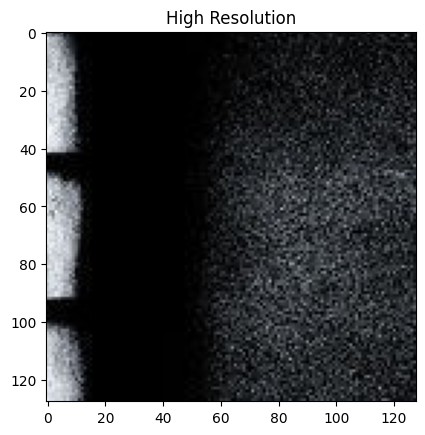

In [9]:
dataset = SRGANImageNet()
print("Total training images:", len(dataset))

sample_image = next(iter(dataset))
sample_image = next(iter(dataset))
print(sample_image['HR'].shape)
plt.title("High Resolution")
plt.imshow(sample_image['HR'].permute(1, 2, 0))

/home/ashutosh/anaconda3/envs/learn/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


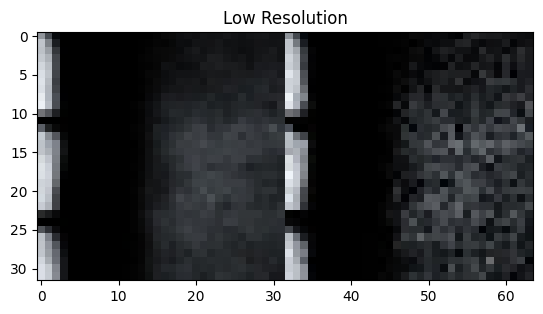

In [10]:
print(sample_image['LR'].shape)

plt.title("Low Resolution")

torch_resize = transforms.Resize((32, 32), interpolation = transforms.InterpolationMode.BICUBIC)(sample_image['HR'])
matlab_lr = sample_image['LR']
lr_images = torch.zeros((2, 3, 32, 32))
lr_images[0, :] = matlab_lr
lr_images[1, :] = torch_resize


plt.imshow(make_grid(lr_images, padding = 0).permute(1, 2, 0))

In [11]:
class RCB(nn.Module):

    def __init__(self, num_channels):
        super(RCB, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(num_channels),
            nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(num_channels)
        )

    def forward(self, lr):
        return lr + self.model(lr)

In [12]:
class UpSampleBlock(nn.Module):

    def __init__(self, channels, upsample_factor):
        super(UpSampleBlock, self).__init__()

        self.upsample_block = nn.Sequential(
            nn.Conv2d(channels, channels * upsample_factor * upsample_factor,  (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upsample_factor),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.upsample_block(x)


In [13]:
class Generator(nn.Module):

  def __init__(self, num_rcbs = 16):
    super(Generator, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 9, stride = 1, padding = 4),
        nn.PReLU()
    )

    # High frequency information extraction RCB Layer
    self.rcb_blocks = []
    for num in range(num_rcbs):
        self.rcb_blocks.append(RCB(64))

    self.rcb_blocks = nn.Sequential(*self.rcb_blocks)

    # High frequency information fusion layer
    self.fusion = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1, bias = False),
        nn.BatchNorm2d(64),
    )

    self.upsample = nn.Sequential(
        UpSampleBlock(64, 2),
        UpSampleBlock(64, 2)
    )

    self.reconstruction = nn.Conv2d(64, 3, kernel_size = 9, stride = 1, padding = 4)

    # Initialize neural network weights
    for module in self.modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)


  def forward(self, lr):
    x = self.conv1(lr)

    x = x + self.fusion(self.rcb_blocks(x))

    up_x = self.upsample(x)

    return self.reconstruction(up_x)

In [14]:
netG = Generator().to(device)

In [15]:
train_dataloader = DataLoader(
    dataset,
    batch_size = 16,
    shuffle = True,
    num_workers = 4,
    pin_memory = True,
    drop_last = False,
    persistent_workers = True
)

In [16]:
test_dataloader = DataLoader(
    TestDataset(),
    batch_size = 1,
    shuffle = True
)

In [17]:
# pixelwise_loss = nn.MSELoss().to(device)
pixelwise_loss = nn.L1Loss().to(device)

In [18]:
class ContentLoss(nn.Module):

    def __init__(
        self,
        feature_nodes = ["features.35"],
        feature_normalize_mean = [ 0.485, 0.456, 0.406 ],
        feature_normalize_std = [ 0.229, 0.224, 0.225 ]
    ):
        super(ContentLoss, self).__init__()
        # Load the pre-trained model
        model = models.vgg19(weights = models.VGG19_Weights.IMAGENET1K_V1)      

        self.feature_extractor = create_feature_extractor(model, feature_nodes)
        self.feature_nodes = feature_nodes

        self.normalize = transforms.Normalize(feature_normalize_mean, feature_normalize_std)

        # Freeze model parameters
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.feature_extractor.eval()

    def forward(self, sr, gt):

        # input normalization
        sr = self.normalize(sr)
        gt = self.normalize(gt)

        sr_features = self.feature_extractor(sr)
        gt_features = self.feature_extractor(gt)

        return F.mse_loss(
                sr_features[self.feature_nodes[0]],
                gt_features[self.feature_nodes[0]])


In [19]:
content_loss = ContentLoss().to(device)

/home/ashutosh/anaconda3/envs/learn/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/ashutosh/anaconda3/envs/learn/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/ashutosh/anaconda3/envs/learn/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/ashutosh/anaconda3/envs/learn/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [20]:
optimizer = Adam(netG.parameters(), lr = 0.0001, betas = [0.9, 0.999], eps = 0.0001, weight_decay = 0.0)

In [21]:
netG = netG.train()

In [22]:
start_epoch = 0
total_epochs = 5

In [23]:
# EXP_NAME = "sr_resnet_4X"
EXP_NAME = "sr_resnet_4X_L1_Content_Loss"

# Create the folder where the model weights are saved
samples_dir = os.path.join("samples", EXP_NAME)
results_dir = os.path.join("results", EXP_NAME)
make_directory(samples_dir)
make_directory(results_dir)

# create model training log
writer = SummaryWriter(os.path.join("samples", "logs", EXP_NAME))

In [24]:
def train(epoch, train_dataloader, optimizer, netG, pixelwise_loss, writer, num_batches):
    tbar = tqdm(train_dataloader)
    total_loss = 0.
    total = 0
    netG.train()
    
    for batch_index, batch in enumerate(tbar):
        # print(batch)
        hr = batch['HR'].to(device)
        lr = batch['LR'].to(device)
        optimizer.zero_grad()

        sr = netG(lr)
        
        loss = pixelwise_loss(sr, hr) + content_loss(sr, hr)

        loss.backward()
        optimizer.step()

        total += 1
        total_loss += loss.item()
        avg_loss = total_loss / total

        # Output training log information once
        if batch_index % 100 == 0:
            # write training log
            iters = batch_index + epoch * num_batches
            writer.add_scalar("Train/Loss", avg_loss, iters)

        tbar.set_description("[Epoch {}] [Avg loss : {:.4f}]".format(epoch + 1, avg_loss))
        tbar.update()

In [25]:
from image_quality_assessment import PSNR, SSIM
def build_iqa_model(
        crop_border,
        only_test_y_channel,
        device
):
    psnr_model = PSNR(crop_border=crop_border, only_test_y_channel=only_test_y_channel, data_range=1.0)
    ssim_model = SSIM(crop_border=crop_border, only_test_y_channel=only_test_y_channel, data_range=255.0)

    psnr_model = psnr_model.to(device)
    ssim_model = ssim_model.to(device)

    return psnr_model, ssim_model


psnr_model, ssim_model = build_iqa_model(
    4,
    True,
    device,
)

In [26]:
def test(epoch, netG, test_dataloader, psnr_model, ssim_model):
    netG.eval()

    with torch.no_grad():
        total_psnr = 0.
        total_ssim = 0.
        count = 0.
        epoch_result_dir = os.path.join(results_dir, "epoch_" + str(epoch))

        make_directory(epoch_result_dir)

        for batch_index, batch in enumerate(test_dataloader):
            gt = batch['HR'].to(device)
            lr = batch['LR'].to(device)

            sr = netG(lr)

            psnr = psnr_model(sr, gt)
            ssim = ssim_model(sr, gt)

            total_psnr += psnr.item()
            total_ssim += ssim.item()

            count += 1

            sr_img = sr.squeeze(0).cpu()
            for i in range(len(batch['filename'])):
                save_image(sr_img, os.path.join(epoch_result_dir, batch['filename'][i]))

        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count

        return avg_psnr, avg_ssim


In [ ]:
num_batches = len(train_dataloader)

best_psnr = 0.
best_ssim = 0.

load_epoch = None

if load_epoch is not None:
    start_epoch = load_epoch
    load_path = os.path.join(samples_dir, "epoch_{}.pth".format(load_epoch))
    checkpoint = torch.load(load_path)

    start_epoch = checkpoint["epoch"]
    best_psnr = max(best_psnr, checkpoint["psnr"])
    best_ssim = max(best_ssim, checkpoint["ssim"])
    netG.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    print("Loaded checkpoint with epoch {}, PSNR {:.4f} and SSIM {:.4f}".format(
        start_epoch, checkpoint["psnr"], checkpoint["ssim"]))


for epoch in range(start_epoch, total_epochs):
    # Train epoch
    train(epoch, train_dataloader, optimizer, netG, pixelwise_loss, writer, num_batches)

    # Test epoch
    psnr, ssim = test(epoch, netG, test_dataloader, psnr_model, ssim_model)

    # Write the evaluation indicators of each round of Epoch to the log
    writer.add_scalar(f"Test/PSNR", psnr, epoch + 1)
    writer.add_scalar(f"Test/SSIM", ssim, epoch + 1)

    best_psnr = max(psnr, best_psnr)
    best_ssim = max(ssim, best_ssim)

    print("[Epoch {}] [Avg PSNR: {:.4f}] [Avg SSIM: {:.4f}]".format(epoch + 1, psnr, ssim))

    save_path = os.path.join(samples_dir, "epoch_{}.pth".format(epoch  + 1))

    torch.save({
        "epoch": epoch + 1,
        "psnr": psnr,
        "ssim": ssim,
        "state_dict": netG.state_dict(),
        "optimizer": optimizer.state_dict()
    }, save_path)

  0%|                                                                                                                              | 0/14663 [00:00<?, ?it/s]/home/ashutosh/anaconda3/envs/learn/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
[Epoch 1] [Avg loss : 0.6720]:  32%|██████████████████████████▋                                                         | 4664/14663 [13:36<29:01,  5.74it/s]

In [ ]:
matlab_lr = transforms.ToTensor()(Image.open("./profile_pic.png"))

plt.imshow(matlab_lr.permute(1, 2, 0))

In [ ]:
matlab_lr = matlab_lr.to(device)
# matlab_lr.unsqueeze(0)
sr_img = netG(matlab_lr.unsqueeze(0))

In [ ]:
sr_img = sr_img.squeeze(0).detach().cpu()
save_image(sr_img, results_dir + "/output.png")

plt.imshow(sr_img.permute(1, 2, 0))